In [1]:
import numpy as np
from scipy import signal
from numpy import linalg as LA
import scipy.io.wavfile as wavfile
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

# Problem 1

In [2]:
fs, x = wavfile.read('vl1.wav')
x = (x/np.max(x)).astype(float)
window = 'hamming'
nperseg = 1024
noverlap = int(1024 * 3/4)

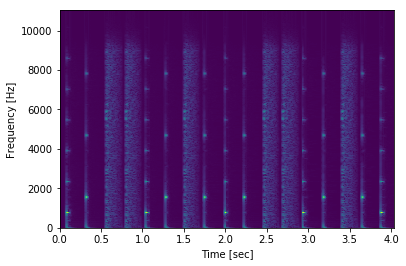

In [3]:
f, t, Zxx = signal.stft(x=x, fs=fs, window=window, nperseg=nperseg, noverlap=noverlap)
X = abs(Zxx)
plt.pcolormesh(t, f, np.sqrt(X))
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

In [4]:
class Model():
    def __init__(self, X):
        self.X = X;
        self.fea_dim = X.shape[0] # feature dimension
        self.sam_dim = X.shape[1] # sample dimension
    
    def PCA(self):
        X_mean = np.mean(self.X, axis=1)
        X_norm = self.X-X_mean[:,None]
        X_cov = (X_norm @ X_norm.T)/(self.sam_dim-1)
        w, v = LA.eig(X_cov)
        w_inverse_sqrt = (w**(-1/2))
        w_inverse_sqrt = np.diag(w_inverse_sqrt)
        self.Zpca = w_inverse_sqrt @ v.T @ X_norm
        self.Wpca = w_inverse_sqrt @ v.T
        return self.Zpca, self.Wpca
    
    def ICA(self, red_dim, steps=500, batch_size=10, lr=1e-3):
        Zred = self.Zpca[0:red_dim].astype(float) # First red_dim PCA weight components
        Wred = np.random.random_sample((red_dim, red_dim)) # First red_dim PCA feature components
        for step in range(steps):
            offset = (step * batch_size) % len(Zred)
            batch_idx = range(offset, min(offset+10, Zred.shape[1]))
            batch = Zred[:, batch_idx]
            fn = 2 * np.tanh(batch)
            batch_T = batch.T
            Niden = len(batch_idx) * np.eye(red_dim)
            Wred += lr * (Niden - fn @ batch_T) @ Wred
        self.Zica = Wred @ Zred
        self.Wica = LA.pinv(Wred @ self.Wpca[0:red_dim])
        return self.Zica, self.Wica
    
    def NMF(self, red_dim, steps=500):
        self.Wnmf = np.random.uniform(low=0, high=1, size=(self.fea_dim, red_dim))
        self.Hnmf = np.random.uniform(low=0, high=1, size=(red_dim, self.sam_dim))
        for step in range(steps):
            self.Wnmf *= (self.X @ self.Hnmf.T)/(self.Wnmf @ self.Hnmf @ self.Hnmf.T + 1e-6)
            self.Hnmf *= (self.Wnmf.T @ self.X)/(self.Wnmf.T @ self.Wnmf @ self.Hnmf + 1e-6)
        return self.Wnmf, self.Hnmf
def plot_components(components, title, model_name, component_name, x_axis):
    plt.figure(figsize=(15,12))
    plt.suptitle(title, size=16)
    plt.subplot(311)
    plt.plot(components[0])
    plt.ylabel('1st %s %s component'%(model_name, component_name))
    plt.xlabel(x_axis)
    plt.subplot(312)
    plt.plot(components[1])
    plt.ylabel('2nd %s %s component'%(model_name, component_name))
    plt.xlabel(x_axis)
    plt.subplot(313)
    plt.plot(components[2])
    plt.ylabel('3rd %s %s component'%(model_name, component_name))
    plt.xlabel(x_axis)
    plt.show()

In [5]:
model = Model(X)
Zpca, Wpca = model.PCA()
Zica, Wica = model.ICA(red_dim=3)
Wnmf, Hnmf = model.NMF(red_dim=3)

/Users/stevenchan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part


# PCA

/Users/stevenchan/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


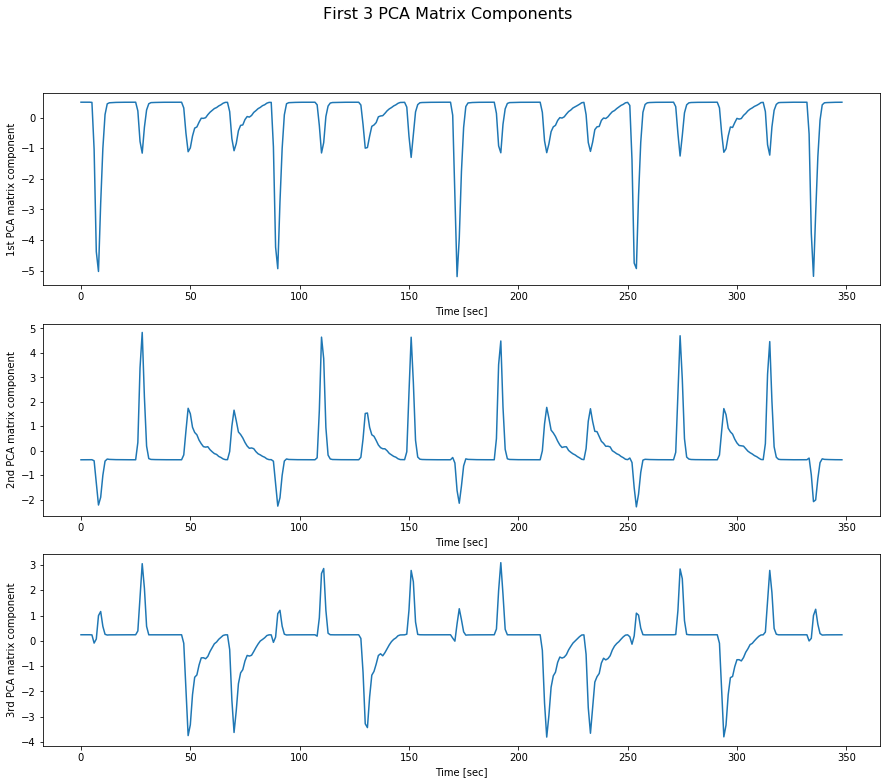

In [6]:
plot_components(Zpca, 'First 3 PCA Matrix Components', 'PCA', 'matrix', 'Time [sec]')

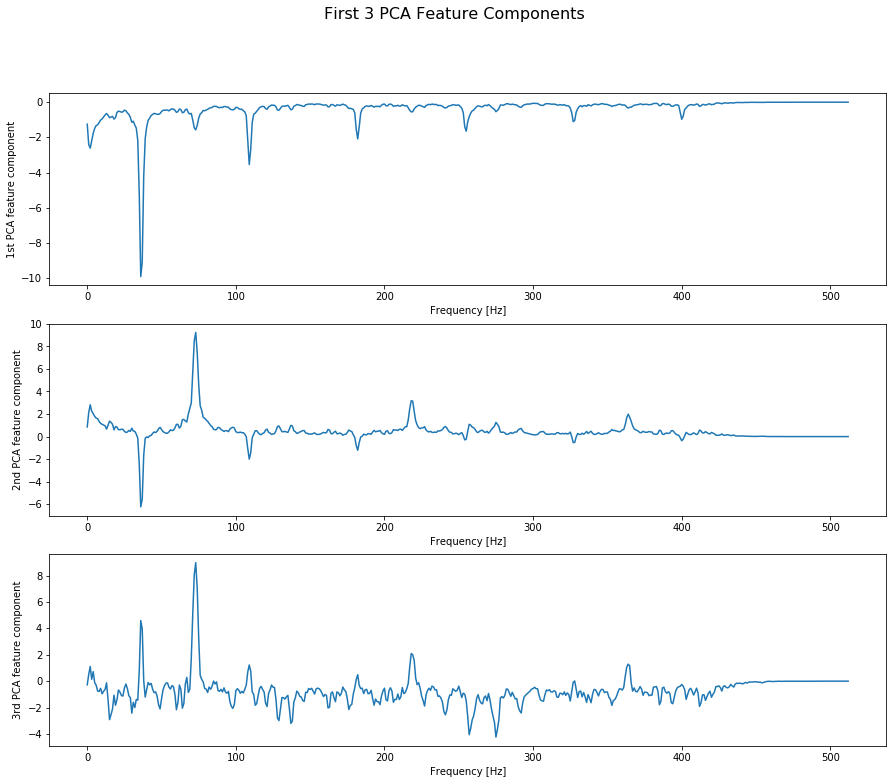

In [7]:
plot_components(Wpca, 'First 3 PCA Feature Components', 'PCA', 'feature', 'Frequency [Hz]')

# ICA

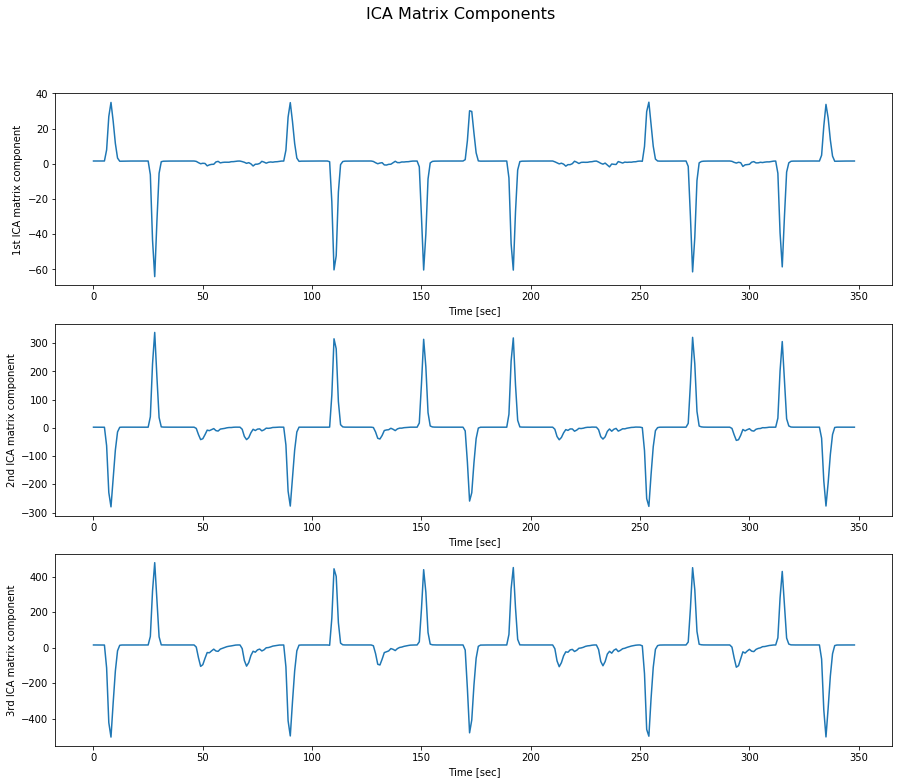

In [8]:
plot_components(Zica, 'ICA Matrix Components', 'ICA', 'matrix', 'Time [sec]')

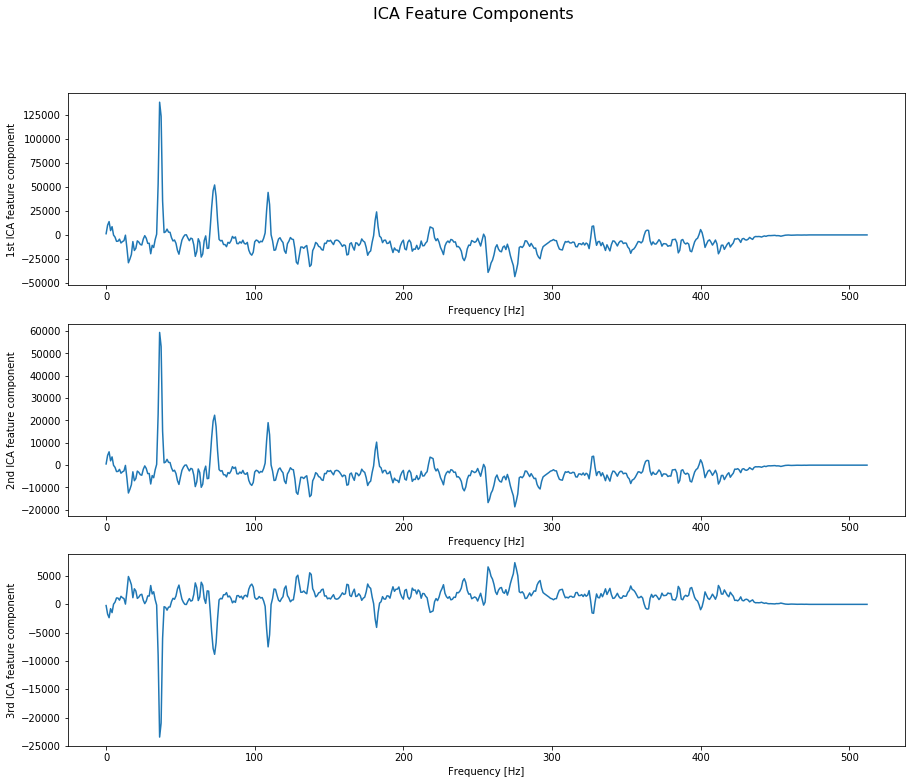

In [9]:
plot_components(Wica.T, 'ICA Feature Components', 'ICA', 'feature', 'Frequency [Hz]')

# NMF

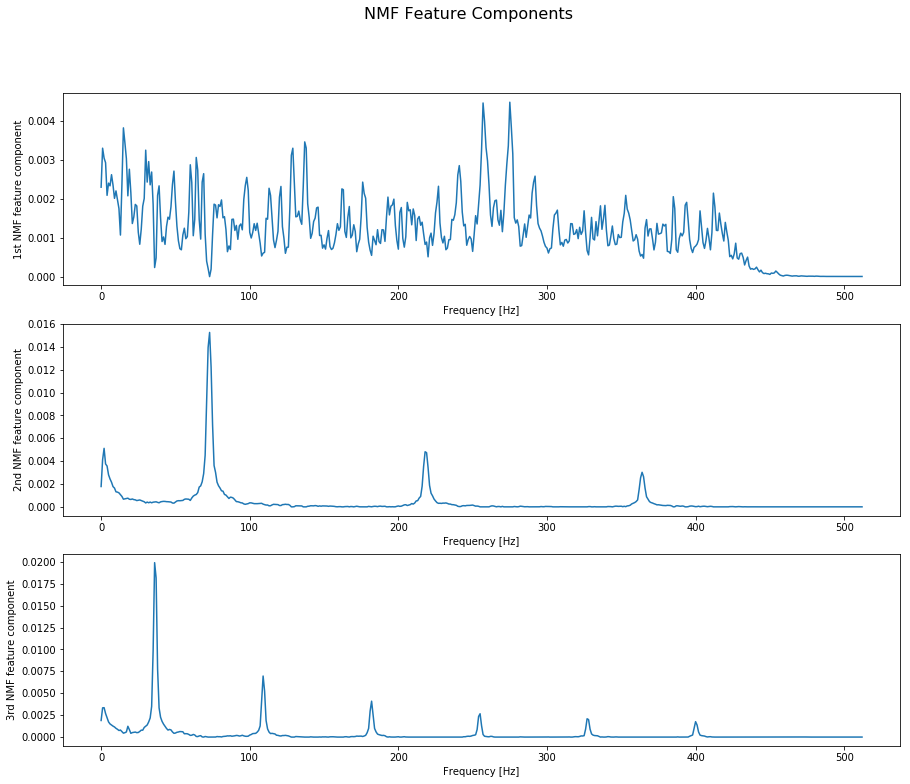

In [10]:
plot_components(Wnmf.T, 'NMF Feature Components', 'NMF', 'feature', 'Frequency [Hz]')

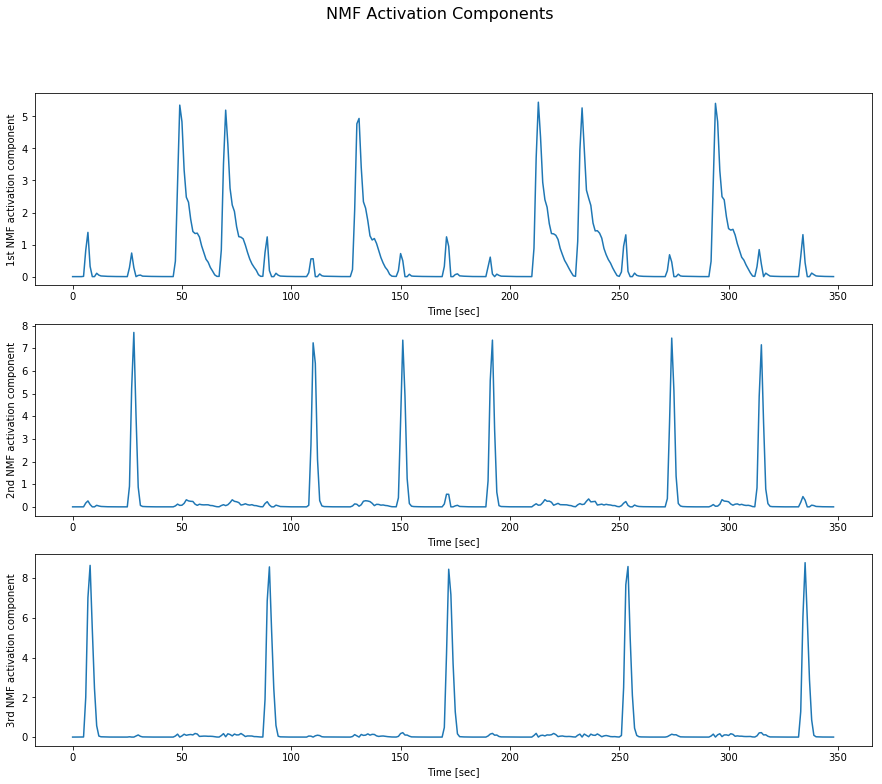

In [11]:
plot_components(Hnmf, 'NMF Activation Components', 'NMF', 'activation', 'Time [sec]')

# ISOMAP

In [12]:
datafile = np.load('digits-labels.npz')
label = datafile['l']
data = datafile['d'].T[np.where(label==6)[0],:]

In [13]:
def ISOMAP(data, label, K=6, red_dim=2):
    def norm_fn(Dg):
        dim = Dg.shape[0]
        H = np.identity(dim) - 1/dim * np.ones((dim, dim))
        return -1/2 * H @ Dg * Dg @ H
    D = euclidean_distances(data, data)
    dim = D.shape[0]
    K_neighbors = D.argsort()
    Dg = np.zeros((dim, dim)) * np.inf
    Dg[:, K_neighbors[0:K]] = D[:, K_neighbors[0:K]]
    for k in range(dim):
        for i in range(dim):
            Dg[i,:] = np.minimum(Dg[i,:], Dg[i,k] + Dg[k,:])
    tau = norm_fn(Dg)
    w, v = LA.eig(tau)
    isomap = np.zeros_like(v[:,:red_dim])
    for i in range(len(isomap)):
        isomap[i] = np.sqrt(abs(w[i])) * v[i, :2]
    return isomap, Dg, tau

In [14]:
isomap, Dg, tau = ISOMAP(data, label)

/Users/stevenchan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in multiply
  if __name__ == '__main__':


In [15]:
def scatter_plot(x, y, images, ax, zoom):
    artists = []
    for (x0, y0, image) in zip(x, y, images):
        im = OffsetImage(image.reshape((28,28)).T, zoom=zoom)
        ab = AnnotationBbox(im, (x0, y0), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()

In [16]:
isomap_plot = isomap[np.where(np.logical_and(np.abs(isomap[:,0])<0.5, np.abs(isomap[:,1])<0.5))[0]]
images_plot = data[np.where(np.logical_and(np.abs(isomap[:,0])<0.5, np.abs(isomap[:,1])<0.5))[0]]

/Users/stevenchan/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/stevenchan/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:591: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)
/Users/stevenchan/anaconda3/lib/python3.6/site-packages/matplotlib/text.py:1785: ComplexWarning: Casting complex values to real discards the imaginary part
  x = float(self.convert_xunits(x))
/Users/stevenchan/anaconda3/lib/python3.6/site-packages/matplotlib/text.py:1787: ComplexWarning: Casting complex values to real discards the imaginary part
  y = float(self.convert_yunits(y))


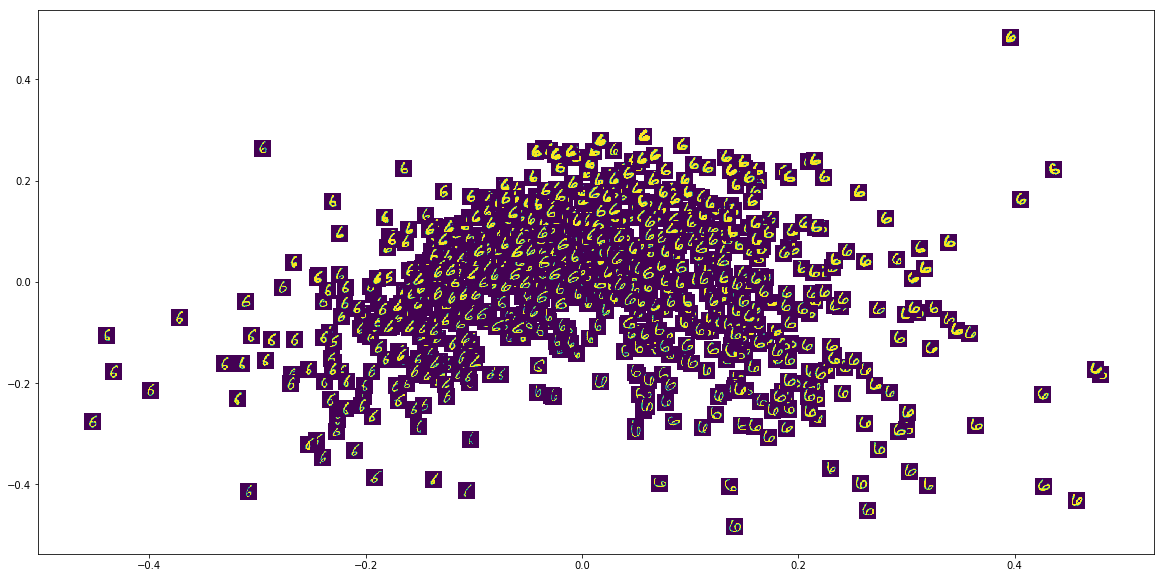

In [17]:
fig, ax = plt.subplots(figsize=(20,10))
scatter_plot(isomap_plot[:,0], isomap_plot[:,1], images_plot, ax=ax, zoom=0.6)
ax.scatter(isomap_plot[:,0], isomap_plot[:,1])
plt.show()